TODO pasar a funciones el cálculo de energía de gen 

In [1]:
# Energy from the ME model

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from energy_analisis import get_energy_consumption_production, get_energy_per_gene
from plot_energy import plot_ME_energy

In [3]:
# load solved ME model
with open('../files/models/iJL1678b_solver.pickle', 'rb') as f:
    me = pickle.load(f)

# ATP consumption per reaction 

In [4]:
# Get the consumption and production of energy per reaction
reactions_energy_consumption,reactions_energy_production = get_energy_consumption_production(me)

In [5]:
energy_consumption = pd.DataFrame.from_dict(reactions_energy_consumption).set_index('Reactions')
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,-3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,-2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,-5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,-1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,-3.812990e-06,-109.0


In [6]:
energy_production = pd.DataFrame.from_dict(reactions_energy_production).set_index('Reactions')
energy_production.head()

,Type,Total,Used,ATP
Reactions,,,,
ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2,MetabolicReaction,1.0,52.367990,1.0
PGK_REV_PGK-CPLX,MetabolicReaction,1.0,12.566816,1.0
PPK2r_REV_PPK-CPLX,MetabolicReaction,1.0,0.000097,1.0
SUCOAS_REV_SUCCCOASYN,MetabolicReaction,1.0,3.955319,1.0


In [7]:
total_produced = energy_production.sum().Used
total_produced

68.89022155075351

In [8]:
# Save file
energy_consumption.to_pickle('../files/energy/energy_per_reaction.pickle')

In [9]:
with open('../files/energy/energy_per_reaction.pickle', 'rb') as f:
    energy_consumption = pickle.load(f)

In [10]:
energy_consumption.loc[:,'Used'] = abs(energy_consumption.Used)
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,3.812990e-06,-109.0


# ATP consumption per gene

In [11]:
total = get_energy_per_gene(energy_consumption, me)

In [12]:
Energia_total_ME = pd.DataFrame(total.items(), columns=['Bnumber', 'Value'])
Energia_total_ME = Energia_total_ME.sort_values(by='Value',ascending=False).reset_index()
Energia_total_ME = Energia_total_ME.loc[:,['Bnumber','Value']]

In [13]:
Energia_total_ME.to_pickle('../files/energy/energy_per_gene.pickle')

In [14]:
Energia_total_ME.head()

,Bnumber,Value
0,b3256,32.329346
1,dummy,1.671482
2,b2752,0.977113
3,b1677,0.232208
4,b0727,0.194296


# ATP consumption (Strains)

In [15]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
strains = names_MG1655+names_W3110

genes_finales = {}

for strain in strains:
    genes_finales[strain] = pd.read_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv')
    genes_finales[strain] = genes_finales[strain].drop(columns= 'Unnamed: 0')

#### Per gene

In [16]:
strain_energy_per_gen={}
for strain in strains:
    genes = genes_finales[strain].Bnumber
    strain_energy_per_gen[strain] = Energia_total_ME.loc[Energia_total_ME.Bnumber.isin(genes)]

#### Per strain

In [17]:
strain_energy_total={}
for strain in strains:
    strain_energy_total[strain] = [strain_energy_per_gen[strain].Value.sum()]
    
strain_energy_total_per={}
for strain in strains:
    strain_energy_total_per[strain] = [(strain_energy_per_gen[strain].Value.sum()*100)/(total_produced)]

In [18]:
consumo = pd.DataFrame.from_dict(strain_energy_total)
consumo = consumo.T.rename(columns={0:'Energy'}).T
consumo_per =  pd.DataFrame.from_dict(strain_energy_total_per)
consumo_per = consumo_per.T.rename(columns={0:'Energy'}).T

In [19]:
consumo

,Δ16,MS56,MDS69,MDS42,MDS12,DGF298,DGF327,MGF02,MGF01
Energy,0.788286,0.172213,0.167337,0.163238,0.163234,0.174018,0.168425,0.004769,0.003504


In [20]:
relevant_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

NameError: name 'np' is not defined

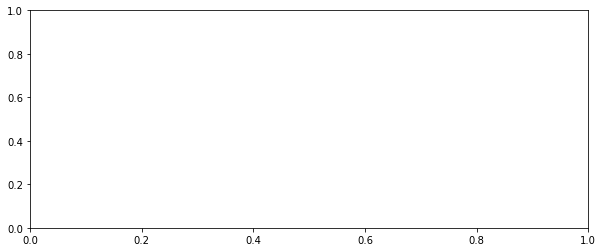

In [21]:
plot_ME_energy(relevant_strains,consumo, consumo_per )

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ["#FFB700",
"#648FFF",
"#82B541",
"#CC002D",
"#9B5EF0",]

new_colors = list(map(lambda x: mcolors.to_rgb(x), colors))
colors=new_colors

In [ ]:
def add_line_MG(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos+ .48], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def add_line_W3(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos+ .39], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,4))

valores=[]
for n in names:
    valores.append(consumo[n].Energy)
valores_p=[]
for n in names:
    valores_p.append(consumo_per[n].Energy)
    
    
labelsize =16
N = len(names[0:5])

ind = np.arange(N)    # the x locations for the groups
print(N)
if N==4:
    width = 0.45       # the width of the bars: can also be len(x) sequence
elif N==5:
    width = 0.8
elif N==9:
    width = 0.75
    
        
lb1 = ax1.bar(ind*1.2, valores[0:5], width, color=colors[0:5], tick_label=names[0:5])
ax1.tick_params( labelsize=labelsize-4)
ax1.set_ylabel('Released ATP\n$mmol•gDW^{-1}•h^{-1}$', fontsize=labelsize-2)

ax2 = ax1.twinx()
ax2.bar(ind*1.2, valores_p[0:5], width, color=colors[0:5], tick_label=names[0:5])
ax2.tick_params(labelsize=labelsize-4)

add_line_MG(ax2, -.1, 0.05)
add_line_W3(ax2, -.1, 0.57)

ax2.text((0.05+.48)/2, -0.17, 'MG1655', transform=ax2.transAxes, fontsize=12) 
ax2.text((0.57)*1.28, -0.17, 'W3110', transform=ax2.transAxes, fontsize=12) 

# plt.yticks(fontsize=labelsize-4)

plt.title('ME Model Genes Related Released Energy',fontweight='bold' ,fontsize=labelsize)
plt.gca().set_yticklabels(['{:.1f}%'.format((x)) for x in plt.gca().get_yticks()]) 
plt.show()